# Init

## Init

In [2]:
import sys, traceback
import cv2
import os
import re
import numpy as np
import argparse
import string
from plantcv import plantcv as pcv
import glob
import os

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
pcv.params.debug = 'plot' 

## Image Selection

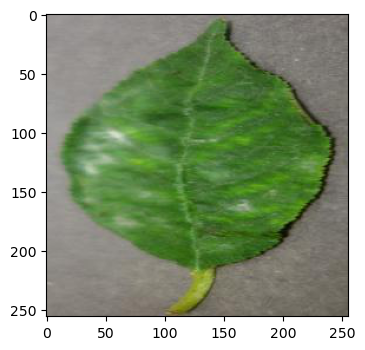

In [211]:
images = glob.glob('../resources/Plant_leave_diseases_dataset_without_augmentation/Cherry*/*')
img=images[10]
img, path, filename = pcv.readimage(img)

### Summary

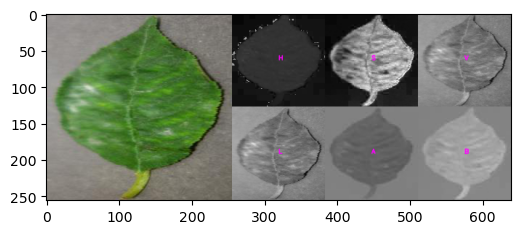

In [212]:
# Analyze Color
analysis_image = pcv.visualize.colorspaces(rgb_img=img)

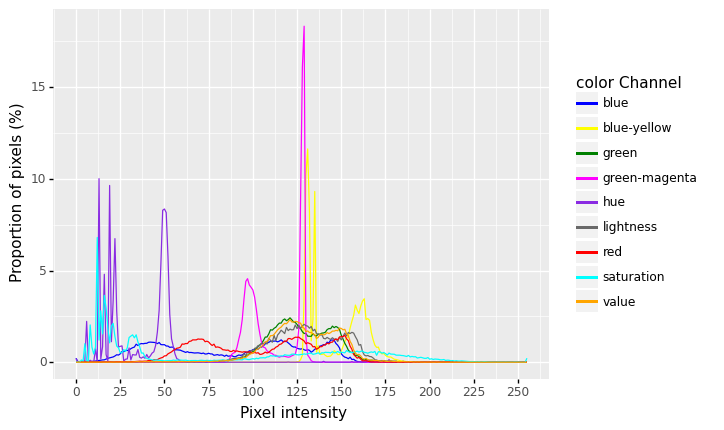

In [213]:
color_histogram = pcv.analyze_color(rgb_img=img, mask=None, colorspaces='all', label="default")

In [214]:
top_y, bottom_y, center_v_y = pcv.y_axis_pseudolandmarks(img=img, obj=None, mask=None, label='default')

## Image modification

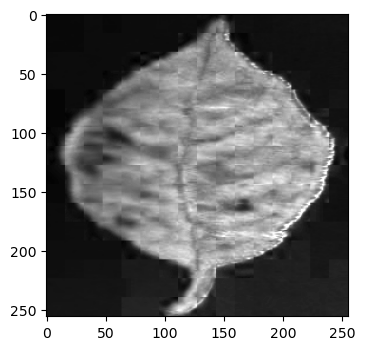

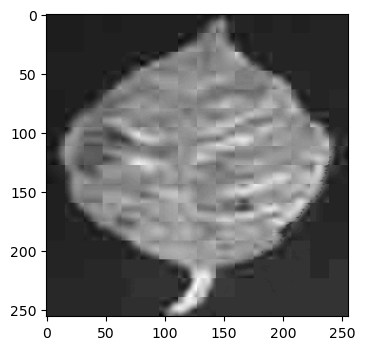

In [217]:
device = 0
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

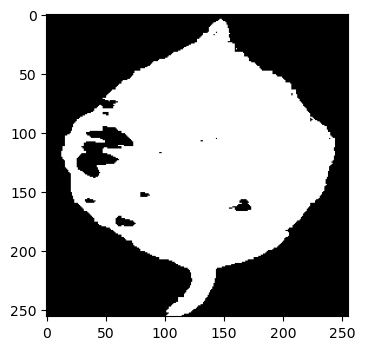

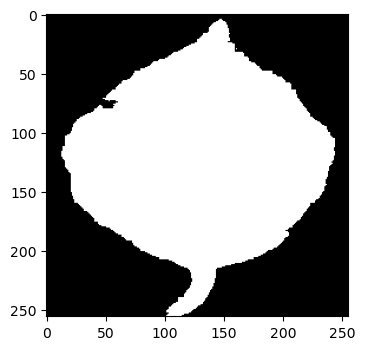

In [219]:
s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
s_thresh = pcv.fill_holes(s_thresh)

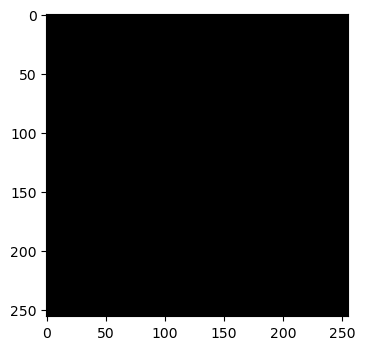

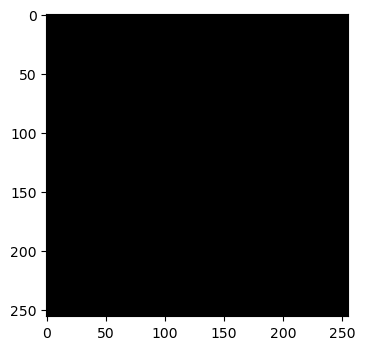

In [218]:
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)

In [ ]:
# Convert RGB to LAB and extract the Blue channel

b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=140, max_value=255, 
                                object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=140, max_value=255, 
                             object_type='light')

# Fill small objects (optional)
# b_fill = pcv.fill(b_thresh, 100)
b_thresh = pcv.fill_holes(b_thresh)

In [ ]:
# Join the thresholded saturation and blue-yellow images
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)

In [ ]:
masked = pcv.apply_mask(img=img, mask=b_fill, mask_color='white')

## Other tests

In [ ]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                       max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                      max_value=255, object_type='light')

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

# Fill small objects
# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab, size=200)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')


In [ ]:
color_histogram = pcv.analyze_color(rgb_img=img, mask=None, colorspaces='all', label="default")
color_histogram = pcv.analyze_color(rgb_img=img, mask=bs, colorspaces='all', label="default")
color_histogram = pcv.analyze_color(rgb_img=masked, mask=None, colorspaces='all', label="default")

In [ ]:
id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=0, y=0, h=img.shape[0], w=img.shape[1])

roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)


In [ ]:

    # Find shape properties, output shape image (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj- Single or grouped contour object
    #   mask - Binary image mask to use as mask for moments analysis  
    #   label - Optional label parameter, modifies the variable name of observations recorded   
    shape_img = pcv.analyze_object(img=img, obj=obj, mask=mask, label="default")

    # Shape properties relative to user boundary line (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj - Single or grouped contour object 
    #   mask - Binary mask of selected contours 
    #   line_position - Position of boundary line (a value of 0 would draw a line 
    #                   through the bottom of the image)
    #   label - Optional label parameter, modifies the variable name of observations recorded  
    boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, 
                                                   line_position=1680, label="default")

    # Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)

    # Inputs:
    #   rgb_img - RGB image data
    #   mask - Binary mask of selected contours 
    #   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
    #                    This is the data to be printed to the SVG histogram file 
    #   label - Optional label parameter, modifies the variable name of observations recorded  
    color_histogram = pcv.analyze_color(rgb_img=img, mask=mask, hist_plot_type='all', label="default")

    # Pseudocolor the grayscale image

    # Inputs:
    #     gray_img - Grayscale image data
    #     obj - Single or grouped contour object (optional), if provided the pseudocolored image gets 
    #           cropped down to the region of interest.
    #     mask - Binary mask (optional) 
    #     background - Background color/type. Options are "image" (gray_img, default), "white", or "black". A mask 
    #                  must be supplied.
    #     cmap - Colormap
    #     min_value - Minimum value for range of interest
    #     max_value - Maximum value for range of interest
    #     dpi - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
    #     axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
    #     colorbar - If False then the colorbar won't be displayed (default colorbar=True)
    pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, mask=mask, cmap='jet')

    # Write shape and color data to results file
    # pcv.print_results(filename=args.result)

In [ ]:
top_x, bottom_x, center_v_x = pcv.y_axis_pseudolandmarks(img=img, obj=obj, mask=mask, label="default")